In [1]:
from jax.config import config
config.update("jax_debug_nans", True)

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from src.lib_phaseshifts import readPHASESHIFTS
from src.lib_tensors import *
from src.lib_tscatf import *
from src.delta import *
from src.delta import _select_phaseshifts

[[[0.05 0.   0.  ]]]


In [44]:
#From "PARAM"
LMAX = 14  # maximum angular momentum to be used in calculation
n_beams = 9  # no. of TLEED output beams
n_atoms = 1  # currently 1 is the only possible choice
n_geo = 1  # number of geometric variations ('displacements') to be considered

# From Stdin
# DR0,DRPER,DRPAR: thermal vibration amplitude steps to be included in
# current variation - DR0 is always 0., DRPER = DRPAR forced
DR0 = 0
DRPER = 0.1908624
DRPAR = DRPER

CDISP = np.full((n_geo, n_atoms, 3),dtype=np.float64,fill_value=np.nan)  # displaced positions of current atomic site for variation
for i in range(n_geo):
    CDISP[i][0][0] = -0.01*i + 0.05
    CDISP[i][0][1] = 0
    CDISP[i][0][2] = 0
print(CDISP)


[[[0.05 0.   0.  ]]]


In [106]:
CDISP = np.array([[[0.05, 0.0, 0.0]]], dtype=np.float64)

In [107]:
# unit vectors in Angstrom
u_vec1 = np.array([1.2722, -2.2036])
u_vec2 = np.array([1.2722,  2.2036])

# area of (overlayer) lateral unit cell - in case TLEED wrt smaller unit cell is used, TVA from reference computation must be set.
unit_cell_area = np.linalg.norm(np.cross(u_vec1, u_vec2))
# In Bohr radii
unit_cell_area = unit_cell_area / BOHR**2

In [108]:
u_vec1*BOHR

array([ 0.67321925, -1.1660949 ])

In [109]:
IEL = 1  # element no. (in phase shifts supplied with input) that delta amplitudes
#          will be calculated for (not necessarily the same element as the one
#          used in the reference calculation!) - IEL = 0 means a vacancy will be assumed

# TODO: check if we ever use this in ViPErLEED
VSITE = 0  # possible energy shift in phase shift computations - can be used to describe
#            local variations of the muffin-tin-constant


In [110]:
phaseshifts_file = Path("PHASESHIFTS")
T1_file = Path("T_1")

In [111]:
_, phaseshifts, _, _ = readPHASESHIFTS(None, None, readfile=phaseshifts_file,
                                       check=False, ignoreEnRange=False)


In [112]:
n_energies = 0
with open(T1_file, 'r') as datei:
    for zeile in datei:
        if '-1' in zeile:
            n_energies += 1


In [113]:
tensor_dict = read_tensor(T1_file, n_beams=9, n_energies= n_energies, l_max=LMAX+1)

# TODO: raise Error if requested energies are out of range respective to
# phaseshift energies (can't interpolate if out of range)

#n_energies = 51
energies = np.array([tensor_dict['e_kin'][i] for i in range(n_energies)])
interpolated_phaseshifts = interpolate_phaseshifts(phaseshifts, LMAX, energies)

all_delwv = np.full((n_energies, n_geo, n_beams), dtype=np.complex128, fill_value=np.nan)
for nc, displacement in enumerate(CDISP):

    d_amplitude = delta_amplitude(tensor_dict, interpolated_phaseshifts, displacement)
    all_delwv[:, nc, :] = d_amplitude


In [114]:
e_inside = tensor_dict['e_kin']  # computational energy inside crystal
t_matrix_ref = tensor_dict['t_matrix']  # atomic t-matrix of current site as used in reference calculation
VV = tensor_dict['v0r']  # real part of the inner potential
v_imag = tensor_dict['v0i_substrate']# imaginary part of the inner potential, substrate

tensor_amps_out = tensor_dict['tensor_amps_out']  # spherical wave amplitudes incident from exit beam NEXIT in "time-reversed"
#                                       LEED experiment (or rather, all terms of Born series immediately after
#                                       scattering on current atom)
tensor_amps_in = tensor_dict['tensor_amps_in']  # spherical wave amplitudes incident on current atomic site in reference calculation
# crop tensors to LMAX
tensor_amps_out = tensor_amps_out[:, :(LMAX+1)**2, :]
tensor_amps_in = tensor_amps_in[:, :(LMAX+1)**2] 
#                                     (i.e., scattering path ends before scattering on that atom)
out_k_par2, out_k_par3 = tensor_dict['kx_in'], tensor_dict['ky_in']  # (negative) absolute lateral momentum of Tensor LEED beams
#                                                        (for use as incident beams in time-reversed LEED calculation)
PSQ = tensor_dict['k_delta']  # lateral momentum of Tensor LEED beams relative to incident beam (0,0)

# NewCAF: working array in which current (displaced) atomic t-matrix is stored
# TODO: we could also either append empty phaseshifts to the phaseshifts array or move the conditional around tscatf
selected_phaseshifts = _select_phaseshifts(IEL, interpolated_phaseshifts)
tscatf_vmap = jax.vmap(tscatf, in_axes=(None, None, 0, 0, None, None, None, None))
t_matrix_new = tscatf_vmap(IEL, LMAX,
                            selected_phaseshifts,
                            e_inside, VSITE, DR0, DRPER, DRPAR)

# amplitude differences
matel_dwg_vmap_energy = jax.vmap(MATEL_DWG, in_axes=(0, 0, 0, 0, None, 0, 0, 0, 0, None, None))
d_amplitude = matel_dwg_vmap_energy(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, displacement)


In [115]:
# Shape: (n_energies, n_beams)
d_amplitude.shape

(51, 9)

# Intensity

In [116]:
from src.lib_intensity import *

In [117]:
# Reference Amplitudes
ref_amps = tensor_dict['ref_amps']

beam_indices = np.array([[1, 0], [0, 1], [1, 1], [2, 0], [0, 2], [2, 1], [1, 2], [3, 0], [0, 3]])

trar = np.empty(shape=(2, 2), dtype="float")
trar[0, :] = u_vec1
trar[1, :] = u_vec2

v_real = tensor_dict['v0r']

theta, phi = 0.0, 0.0

is_surface_atom = np.array([True]) # topmost atom is surface atom

In [118]:
prefactors = intensity_prefactor(CDISP, e_inside, v_real, v_imag, beam_indices, theta, phi, trar, is_surface_atom)
prefactors.shape  # (n_energies, n_beams)

(51, 9)

In [124]:
lam_prefactor = lambda c: intensity_prefactor(c, e_inside, v_real, v_imag, beam_indices, theta, phi, trar, is_surface_atom)

In [ ]:
intensity = sum_intensity(prefactors, ref_amps, d_amplitude)

In [119]:
d_intensities = prefactors*abs(ref_amps + d_amplitude)**2

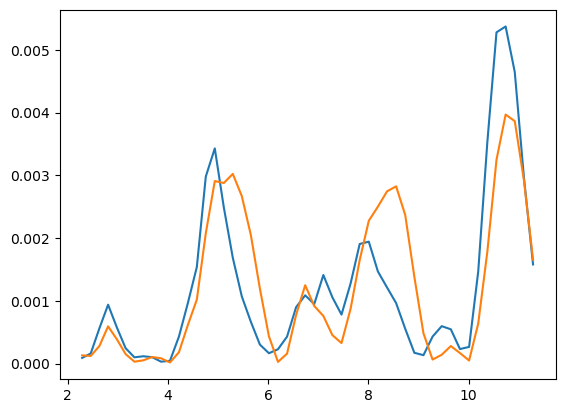

In [123]:
plt.plot(e_inside, (prefactors*abs(ref_amps)**2)[:,0])
plt.plot(e_inside, d_intensities[:, 0])

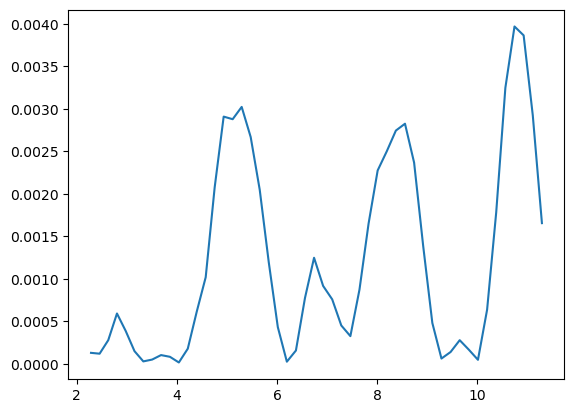

In [121]:
plt.plot(e_inside, d_intensities[:, 0])

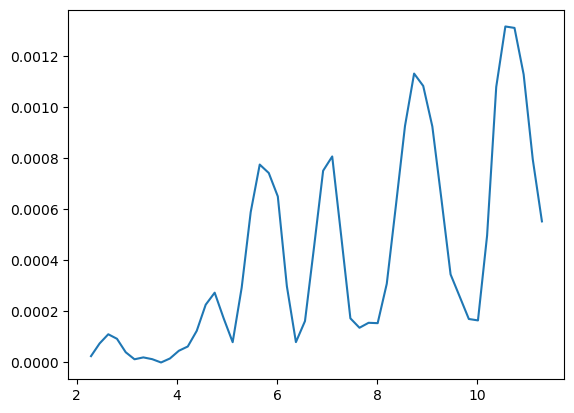

In [122]:
plt.plot(e_inside, abs(d_amplitude[:, 0])**2)